
## Print figures of Himawari SST data in regions (distributed)


In [1]:
import os, sys, shutil
from glob import glob
#
%matplotlib inline
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import xarray as xr
from dask_jobqueue import PBSCluster
from dask import compute, delayed
from dask.distributed import Client
# 
from datetime import datetime
import pandas as pd
#
from utils import *

/home1/datahome/aponte/distributed/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
/home1/datahome/aponte/.miniconda3/envs/pangeon/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


satpy not available


In [2]:
# launch cluster and workers
#cluster = PBSCluster(queue='mpi_1', local_directory=os.getenv('DATAWORK')+'/dask', interface='ib0', \
cluster = PBSCluster(queue='mpi_1', local_directory=os.getenv('HOME')+'/dask_scratch', interface='ib0', \
                     threads=4, processes=7, memory='10GB', resource_spec='select=1:ncpus=28:mem=100g')
cluster.start_workers(4)

[2, 3, 4, 5]

In [3]:
cluster.scheduler

<Scheduler: "tcp://10.148.1.108:50081" processes: 28 cores: 112>

In [4]:
### get dask handles and check dask server status
client = Client(cluster)
#client = Client(scheduler_file=os.path.expanduser('/home1/scratch/aponte/dask/scheduler.json'), timeout='20s')
# upload utils.py to workers
#client.upload_file('utils.py')

In [5]:
client

Client Scheduler: tcp://10.148.1.108:50081 Dashboard: http://10.148.1.108:8787/status,Cluster Workers: 28 Cores: 112 Memory: 280.00 GB


## the dashboard correctly shows workers

In [6]:
cluster.stop_workers(cluster.jobs)

In [7]:
cluster.start_workers(4)

[6, 7, 8, 9]

## the dashboard correctly shows workers

In [8]:
client.restart()

distributed.scheduler - ERROR - Not all workers responded positively: ['timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out']
NoneType: None
distributed.client - ERROR - Restart timed out after 5.000000 seconds


Client Scheduler: tcp://10.148.1.108:50081 Dashboard: http://10.148.1.108:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## the dashboard correctly shows workers

In [10]:
#client.restart()
#client.upload_file('/home1/datahome/aponte/iwave_sst/hw/utils.py')
client.upload_file('utils.py')

In [11]:
# data path
region = 'NWA'; vmin = 20.; vmax = 35.
region = 'NWAM'; vmin = 26.; vmax = 32.
region = 'WA'; t1, t2, suff, vmin, vmax, slat, slon = datetime(2016,9,3), datetime(2016,9,16), '_t1z', 23., 30., slice(-12,-24), slice(108,126)

#
dpath = '/home/datawork-lops-osi/data/hw/sst/'+region+'/';
#figdir = '/home1/datawork/aponte/hw/figs/'

filenames = sorted(glob(dpath+region+'_*.nc'))
print('Number of files available: %d' %len(filenames))
Nfiles = len(filenames)
# tmp, subset number of files (skip last file that may be incomplete)
#filenames = filenames[:-1]

# consider a time subset
times = [datetime.strptime(f,dpath+region+'_%Y%m%d%H%M.nc') for f in filenames]
if 't1' in locals() and 't2' in locals():
    filenames  = [f for f,t in zip(filenames,times) if (t>t1) and (t<t2)]
print('Number of files processed: %d' %len(filenames))

Number of files available: 44359
Number of files processed: 1842


In [12]:
# open files
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')

# spatial zoom
if 'slat' in locals():
    ds = ds.sel(lat=slat)

# sst in degC
ds['sea_surface_temperature'] += -273.15
ds['sea_surface_temperature'] = ds['sea_surface_temperature'].where(ds['sea_surface_temperature']>0)

print('SST dataset size: %.1f GB' %(ds['sea_surface_temperature'].nbytes/1e9))

CPU times: user 44.1 s, sys: 3.72 s, total: 47.8 s
Wall time: 1min 29s
SST dataset size: 4.4 GB


In [13]:
ds

<xarray.Dataset>
Dimensions:                  (lat: 601, lon: 1001, time: 1842)
Coordinates:
  * lat                      (lat) float32 -12.0 -12.019997 -12.040001 ...
  * lon                      (lon) float32 105.0 105.02 105.04 105.06 105.08 ...
  * time                     (time) datetime64[ns] 2016-09-03T00:10:17 ...
Data variables:
    sea_surface_temperature  (time, lat, lon) float32 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
    wind_speed               (time, lat, lon) float32 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
    solar_zenith_angle       (time, lat, lon) float32 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
Attributes:
    Conventions:                CF-1.4,Unidata Observation Dataset v1.0
    title:                      Sea Surface Temperature from AHI onboard Hima...
    summary:                    TBD
    references:                 TBD
    institution:                Japan Aerospace Exploration Agency(JAXA)
  

---

# mean quantities

/home1/datahome/aponte/.miniconda3/envs/pangeon/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


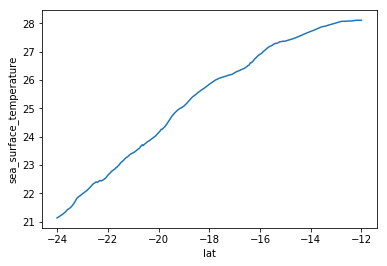

In [14]:
Tmean_xt = ds['sea_surface_temperature'].mean(['lon','time']).persist()
Tmean_xt.plot()

In [ ]:
Tmean_xy = ds['sea_surface_temperature'].mean(dim=['lon','lat'])
Tmean_xy.plot()
plt.grid()

In [ ]:
Tmean_t = ds['sea_surface_temperature'].mean('time').persist()

In [ ]:
plot_sst(Tmean_t, title='Temporal average', vmin=22., vmax=28., figsize=(15,10))

---

# diurnal cycle

In [ ]:
Tdcycle = (ds['sea_surface_temperature'].mean('lon') - Tmean_xt).groupby('time.hour').mean('time')
Tdcycle = Tdcycle.persist()

In [ ]:
Tdcycle

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
Tdcycle.T.plot(ax=ax)

In [ ]:
Tdcycle.mean('lat').plot()
plt.grid()

---

# zonally averaged temperature

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
(ds['sea_surface_temperature'].mean('lon') - Tmean_xt).T.plot(ax=ax, vmin=-1., vmax=1.)
plt.grid()

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
#ds['wind_speed'].mean('lon').T.plot(ax=ax, vmin=-1., vmax=1.)
ds['wind_speed'].mean('lon').T.plot(ax=ax)

---

# At single longitudes

In [ ]:
T = ds['sea_surface_temperature'].sel(lon=116.,method='nearest')
T = T.sel(lat=slice(-15.,-21.5))
#T = T.sel(time=slice('2016-09-04','2016-09-15'))
T += -T.mean('time')

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
T.T.plot(ax=ax, vmin=-1., vmax=1.)
ax.grid()

In [ ]:
T = ds['sea_surface_temperature'].sel(lon=120.,method='nearest')
T = T.sel(lat=slice(-12.,-20.))
#T = T.sel(time=slice('2016-09-04','2016-09-15'))
T += -T.mean('time')

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
T.T.plot(ax=ax, vmin=-1., vmax=1.)
ax.grid()

In [ ]:
# clean up memory
del Tdcycle, Tmean_xt, Tmean_t

---

# make movie

In [21]:

figdir = '/home1/datawork/aponte/hw/figs/'
shutil.rmtree(figdir); os.mkdir(figdir)

def process(lds, i, overwrite=True):
    sst = lds['sea_surface_temperature']
    #
    time = pd.to_datetime(str(sst['time'].values))
    figname = figdir+'hw_sst_'+region+'_'+time.strftime('%Y%m%d_%H%M')+suff+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = time.strftime('%Y%m%d_%H%M')
        plot_sst(sst, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                 offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(sst.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
I = range(5)
#values = [delayed(process)(ds['sea_surface_temperature'].isel(time=i), i) for i in I]
values = [delayed(process)(ds.isel(time=i), i) for i in I]
#print(values[:5])


In [22]:
results = compute(*values, get=client.get)

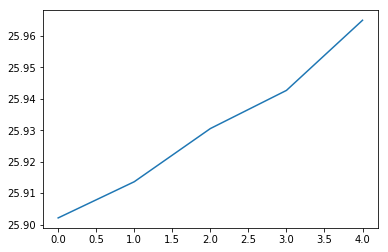

In [23]:
plt.plot(results)

In [26]:
# with delayed
def process(lds, i):
    sst = lds['sea_surface_temperature']
    #
    m = float(sst.mean().values)
    return m

I = range(len(ds['time']))
values = [delayed(process)(ds.isel(time=i), i) for i in I]
#print(values[:5])

In [27]:
results = compute(*values, get=client.get)

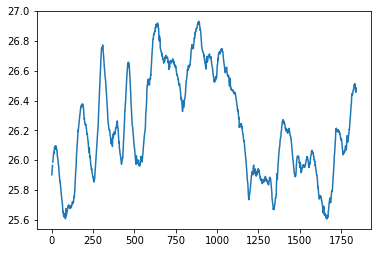

In [28]:
plt.plot(results)

In [24]:

# with apply_ufunc
def process(T, lon, lat, time):
    #
    #plot_sst(sst, colorbar=False, title=title, savefig=figname, 
    #         vmin=vmin, vmax=vmax, offline=True, coast_resolution='50m', figsize=(15,10))
    #
    plt.switch_backend('agg')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(T.squeeze())
    #figname = figdir+'hw_sst_'+region+'_'+time.strftime('%Y%m%d_%H%M')+suff+'.png'    
    figname = figdir+'hw_sst_'+region+'_'+str(time)+'.png'    
    fig.savefig(figname, dpi=150)
    plt.close(fig)
    #
    m = np.nanmean(np.nanmean(T,axis=1),axis=1)
    return m
    
M = xr.apply_ufunc(process, ds['sea_surface_temperature'].isel(time=slice(0,10)), 
                   ds['lon'], ds['lat'], ds['time'].isel(time=slice(0,10)),
                   input_core_dims=[['lon','lat'],['lon'],['lat'],[]], 
                   dask='parallelized', output_dtypes=[float])

print(M)

1842

In [ ]:
M.compute()

---

In [10]:
#client.close()
cluster.stop_workers(cluster.jobs)

qdel: Job has finished

